In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import torch

if torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"
device = torch.device(dev)

In [ ]:
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import tifffile

#############################################
# 路徑轉換
#############################################
def convert_path(path):
    """將 Windows 路徑轉換為適用格式"""
    return path.replace('\\', '/')

#############################################
# 掃描區遮罩函數
#############################################
def mask(output):
    """
    依據影片前處理的遮罩規則：
      - 產生 m1、m2 網格
      - 僅保留 (m1+m2) 大於 (dimension/2 + dimension/10)
        且 (m1-m2) 小於 (dimension/2 + dimension/10) 的區域
      - 利用 cv2.bitwise_and 套用遮罩
    """
    dimension = output.shape[0]
    m1, m2 = np.meshgrid(np.arange(dimension), np.arange(dimension))
    msk = ((m1 + m2) > int(dimension / 2) + int(dimension / 10))
    msk *= ((m1 - m2) < int(dimension / 2) + int(dimension / 10))
    msk = np.reshape(msk, (dimension, dimension)).astype(np.int8)
    maskedImage = cv2.bitwise_and(output, output, mask=msk)
    return maskedImage

#############################################
# 前處理函數：圖片與遮罩的處理方法不同
#############################################
def preprocess_image_pil(pil_img, output_size=(256, 256), is_mask=False):
    """
    對 PIL.Image 進行前處理：
      1. 強制轉為灰階（'L' 模式）
      2. 以圖片最短邊為基準，從中心區域裁切出正方形區域，再扣除左右上下邊界 margin 
         （margin = int(min_dim/10)）
      3. 調整尺寸：
           - 若為一般圖片，採用 BICUBIC 插值（平滑效果佳）
           - 若為遮罩（is_mask=True），採用 NEAREST 插值，避免產生中間值
      4. 轉成 numpy 陣列後，呼叫 mask() 套用掃描區遮罩
    """
    pil_img = pil_img.convert('L')
    w, h = pil_img.size  # (width, height)
    min_dim = min(w, h)
    margin = int(min_dim / 10)
    left = int((w - min_dim) / 2) + margin
    top = int((h - min_dim) / 2) + margin
    right = int((w + min_dim) / 2) - margin
    bottom = int((h + min_dim) / 2) - margin
    cropped = pil_img.crop((left, top, right, bottom))
    
    # 根據是否為遮罩選擇插值方法
    interpolation = Image.NEAREST if is_mask else Image.BICUBIC
    resized = cropped.resize(output_size, interpolation)
    
    np_img = np.array(resized)
    processed = mask(np_img)
    return processed

#############################################
# 處理一對圖片與遮罩：分別依據不同插值處理
#############################################
def process_pair(image_path, mask_path, output_folder, prefix="processed_"):
    """
    讀取一對原始檔案：
      - JPG 圖片使用 PIL 讀取，前處理時採用 BICUBIC 插值
      - TIF 遮罩使用 tifffile 讀取，若多通道則僅取第一通道，再轉換為 PIL.Image，前處理時採用 NEAREST 插值
    處理後存檔至 output_folder，並回傳處理後的完整路徑
    """
    try:
        pil_img = Image.open(image_path).convert('L')
    except Exception as e:
        print(f"讀取 JPG 失敗: {image_path}，錯誤：{e}")
        return None, None
    processed_image = preprocess_image_pil(pil_img, output_size=(256, 256), is_mask=False)
    
    try:
        raw_mask = tifffile.imread(mask_path)
        if len(raw_mask.shape) > 2:
            raw_mask = raw_mask[:, :, 0]
        pil_mask = Image.fromarray(raw_mask)
    except Exception as e:
        print(f"讀取 TIF 失敗: {mask_path}，錯誤：{e}")
        return None, None
    processed_mask = preprocess_image_pil(pil_mask, output_size=(256, 256), is_mask=True)
    
    os.makedirs(output_folder, exist_ok=True)
    image_filename = os.path.basename(image_path)
    mask_filename = os.path.basename(mask_path)
    processed_image_path = os.path.join(output_folder, prefix + image_filename)
    processed_mask_path = os.path.join(output_folder, prefix + mask_filename)
    
    cv2.imwrite(processed_image_path, processed_image)
    cv2.imwrite(processed_mask_path, processed_mask)
    print(f"處理完成：{image_filename} 與 {mask_filename}")
    return processed_image_path, processed_mask_path

#############################################
# 處理整個 masklab 資料集，並產生新的 CSV
#############################################
def process_masklab_dataset(csv_file, root_dir, output_folder, new_csv_file, prefix="processed_"):
    """
    1. 讀取 masklab_results.csv（若有 Confidence 與 Prediction 欄位，先進行篩選）
    2. 根據 reviewed_data_results.csv 的 Keep 欄位進一步過濾（僅保留 Keep 的檔案）
    3. 根據每筆資料，計算 JPG 與 TIF 的完整路徑（mask_path 透過將 .jpg 改成 .tif）
    4. 檢查檔案存在性，呼叫 process_pair() 進行前處理並存檔
    5. 將處理成功的資料建立新記錄，更新 'Filename' 為處理後圖片的相對路徑，
       並新增 'MaskFilename' 欄位指向處理後遮罩的相對路徑
    6. 最後將新記錄存成新的 CSV
    """
    df = pd.read_csv(csv_file)
    # 初步篩選（若有相關欄位）
    if 'Confidence' in df.columns and 'Prediction' in df.columns:
        df = df[(df['Confidence'] > 0.8) & (df['Prediction'].isin(['a4c', 'a5c']))]
    
    # 根據 reviewed_data_results.csv 進一步篩選
    if os.path.exists(reviewed_csv):
        reviewed_data = pd.read_csv(reviewed_csv)
        keep_data = reviewed_data[reviewed_data['Keep'] == 'Keep']
        df = df[df['Filename'].isin(keep_data['Filename'])]
    
    new_records = []
    for idx, row in df.iterrows():
        img_filename = row['Filename']
        img_path = os.path.join(root_dir, convert_path(img_filename))
        mask_path = img_path.replace('.jpg', '.tif')
        
        if not os.path.exists(img_path):
            print(f"找不到圖片檔案：{img_path}")
            continue
        if not os.path.exists(mask_path):
            print(f"找不到遮罩檔案：{mask_path}")
            continue
        
        processed_image_path, processed_mask_path = process_pair(img_path, mask_path, output_folder, prefix)
        if processed_image_path is None or processed_mask_path is None:
            continue
        
        # 更新記錄：將處理後的檔案路徑（相對於 output_folder）存入 CSV
        new_row = row.copy()
        new_row['Filename'] = os.path.relpath(processed_image_path, output_folder)
        new_row['MaskFilename'] = os.path.relpath(processed_mask_path, output_folder)
        new_records.append(new_row)
    
    if new_records:
        new_df = pd.DataFrame(new_records)
        new_df.to_csv(new_csv_file, index=False)
        print(f"新 CSV 已產生：{new_csv_file}")
    else:
        print("沒有處理成功的檔案，新 CSV 未產生。")

#############################################
# 主程式入口
#############################################
if __name__ == "__main__":
    csv_file = "masklab_results.csv"
    root_dir = "masklab"             # 此資料夾中應包含原始的 JPG 與 TIF 檔案
    output_folder = "processed_masklab"  # 處理後影像存放資料夾
    new_csv_file = "processed_masklab_results.csv"  # 新 CSV 檔案
    reviewed_csv = 'reviewed_data_results.csv' # 人工篩選後希望使用的A4C資料
    process_masklab_dataset(csv_file, root_dir, output_folder, new_csv_file)


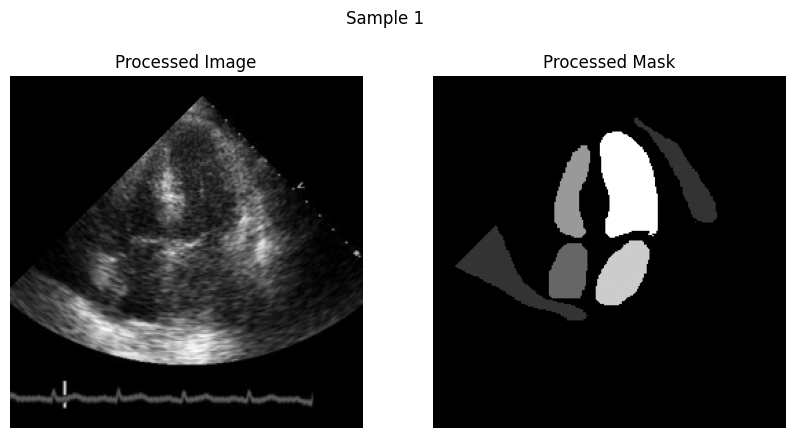

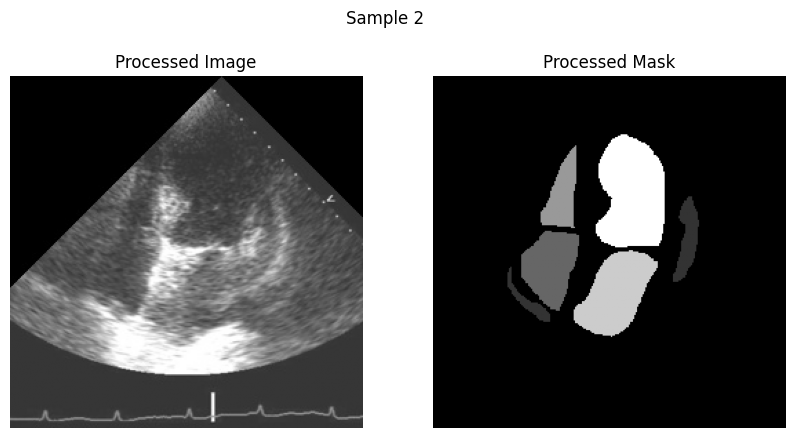

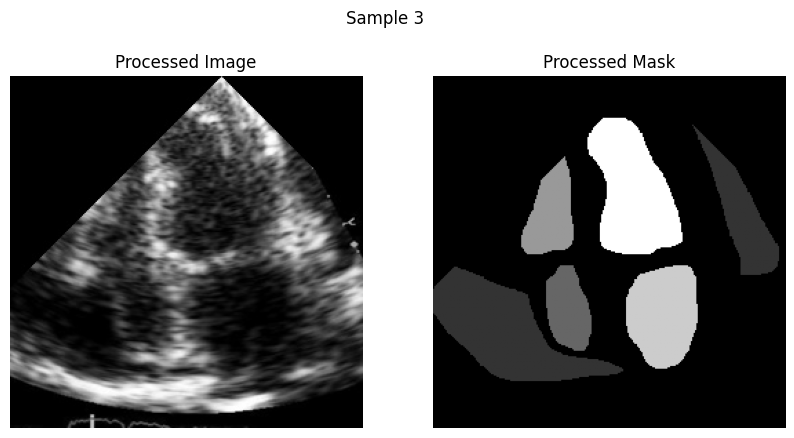

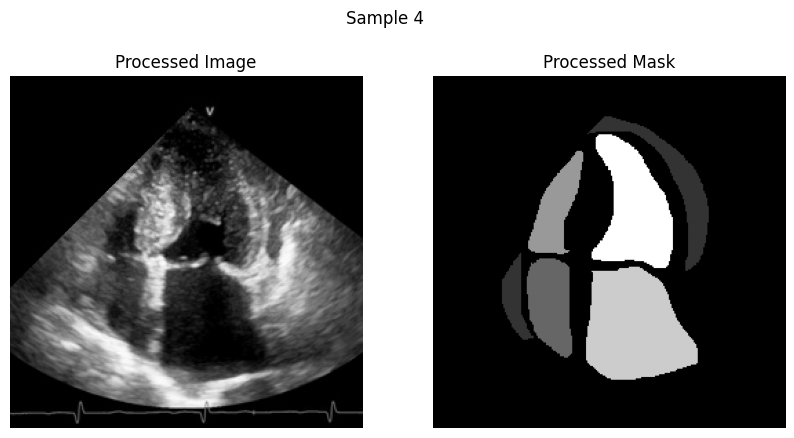

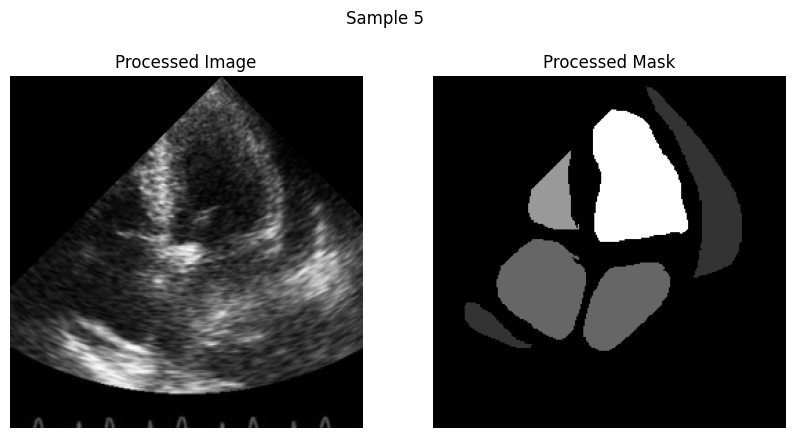

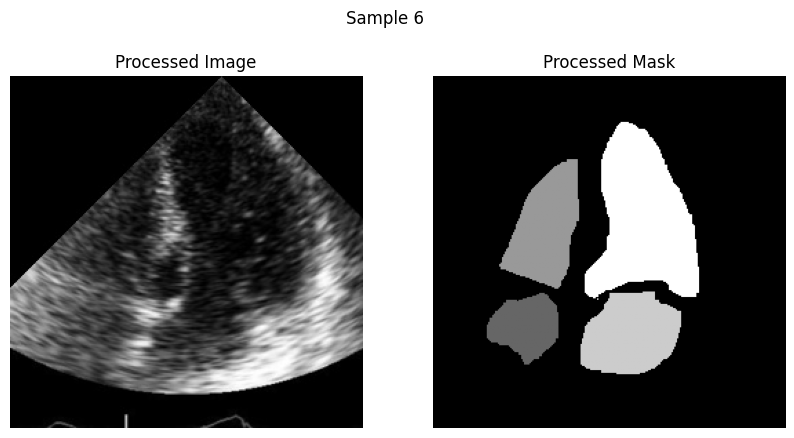

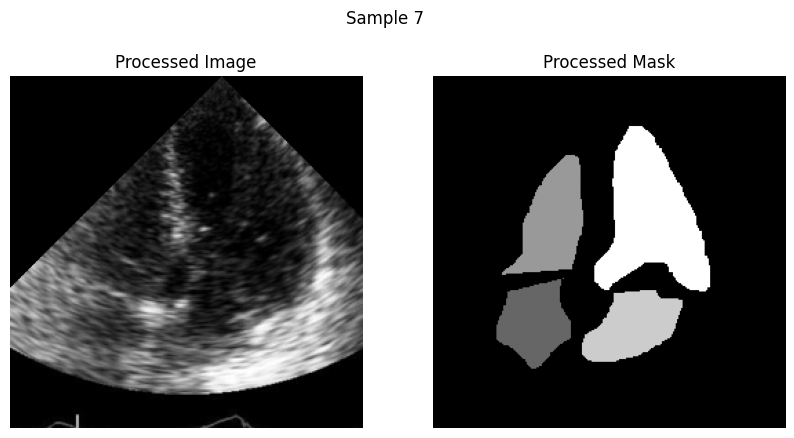

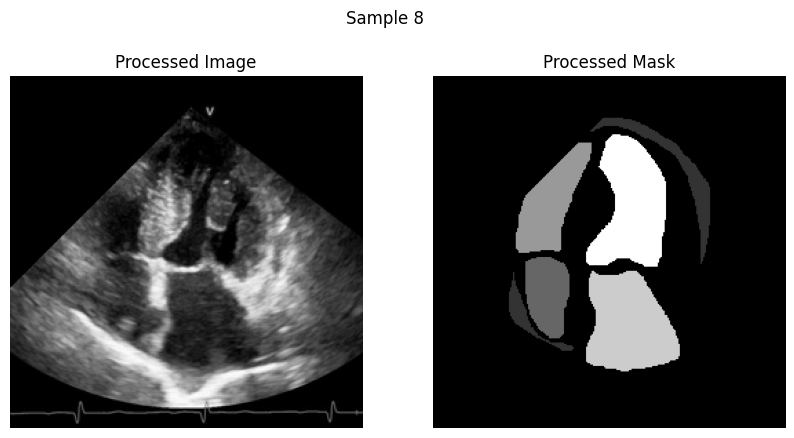

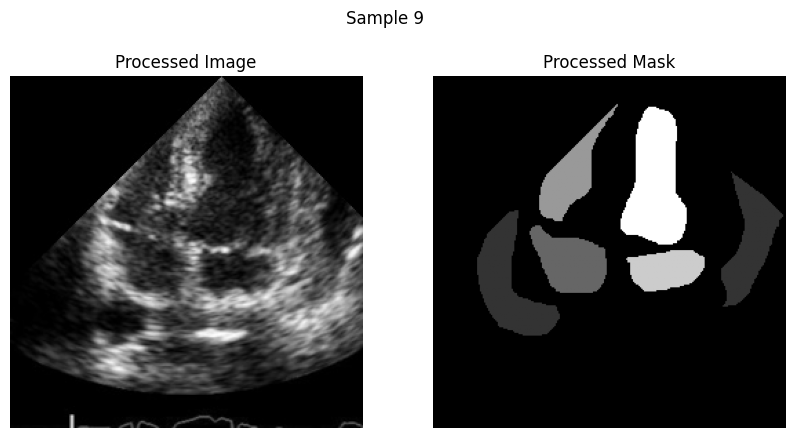

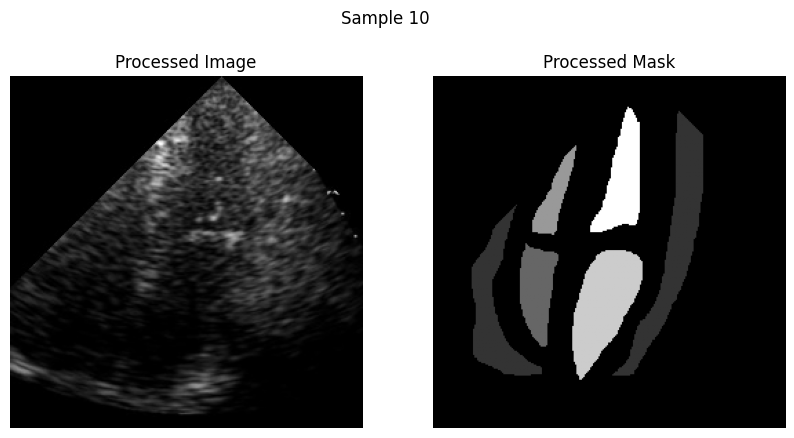

In [ ]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# 設定 processed_masklab 資料夾與新的 CSV 路徑
processed_folder = 'processed_masklab'
csv_file = 'processed_masklab_results.csv'

# 讀取 CSV
df = pd.read_csv(csv_file)

# 顯示前 10 組對應圖片與遮罩
num_display = 10
for i in range(min(num_display, len(df))):
    row = df.iloc[i]
    image_path = os.path.join(processed_folder, row['Filename'])
    mask_path = os.path.join(processed_folder, row['MaskFilename'])
    
    # 讀取影像（以灰階模式）
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # 建立圖表
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Processed Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(msk, cmap='gray')
    plt.title('Processed Mask')
    plt.axis('off')
    
    plt.suptitle(f"Sample {i+1}")
    plt.show()
